# Multi-Channel Convolutional Neural Network (CNN) Model for Text Classification

## 1. Movie Review Dataset

- The Movie Review Data is a collection of movie reviews retrieved from imdb.com in the early 2000s by Bo Pang and Lillian Lee. The reviews were collected and made available as part of their research on natural language processing. The reviews were originally released in 2002, but an updated and cleaned up version were released in 2004, referred to as “v2.0”.

- The dataset is comprised of 1,000 positive and 1,000 negative movie reviews drawn from an archive of rec.arts.movies.reviews newsgroup hosted at imdb.com. The authors refer to this dataset as the “polarity dataset.”

- The data has been cleaned up somewhat, for example:
    - The dataset is comprised of only English reviews.
    - All text has been converted to lowercase.
    - There is white space around punctuation like periods, commas and brackets.
    - Text has been split into one sentence per line.

- The data has been used for a few related natural language processing tasks. For classification, the performance of machine learning models (such as Support Vector Machines) on the data is in the range of high 70% to low 80% (e.g. 78%-82%).

- More sophisticated data preparation may see results as high as 86% with 10-fold cross validation. This gives us a ballpark of low-to-mid 80s if we were looking to use this dataset in experiments of modern methods.

- You can download the dataset from here :- [Movie Review Polarity Dataset](http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz) (review_polarity.tar.gz, 3MB)

- After unzipping the file, you will have a directory called “txt_sentoken” with two sub-directories containing the text “neg” and “pos” for negative and positive reviews respectively. Reviews are stored one per file with a naming convention cv000 to cv999 for each neg and pos.

In [1]:
# import necessary libraries
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from os import listdir
from numpy import array
from pickle import dump, load
import tensorflow as tf
import matplotlib.pyplot as plt

# print tensorflow version
print(f'TensorFlow Version is {tf.__version__}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
TensorFlow Version is 2.2.0


[tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file)

In [0]:
# dataset URL
#URL = 'http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz'
# get dataset and extract
#path = tf.keras.utils.get_file('review_polarity', origin=URL, extract=True, cache_dir='/content/')
#print(f'Path : {path}')

In [2]:
# download the dataset
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2020-06-15 13:32:12--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  1.70MB/s    in 1.8s    

2020-06-15 13:32:15 (1.70 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



In [0]:
# extract the data
!tar -xf review_polarity.tar.gz

## 2. Data Preparation

In this section, we will look at 3 things:

- A. Separation of data into training and test sets.
- B. Loading and cleaning the data to remove punctuation and numbers.
- C. Prepare all reviews and save to file.

### A. Split into Train and Test Sets
- We are pretending that we are developing a system that can predict the sentiment of a textual movie review as either positive or negative. This means that after the model is developed, we will need to make predictions on new textual reviews. This will require all of the same data preparation to be performed on those new reviews as it is performed on the training data for the model.

- We will ensure that this constraint is built into the evaluation of our model by splitting the training and test datasets prior to any data preparation. This means that any knowledge in the data in the test set that could help us better prepare the data (e.g. the words used) are unavailable in the preparation of data used for training the model.

- That being said, we will use the last 100 positive reviews and the last 100 negative reviews as a test set (100 reviews) and the remaining 1,800 reviews as the training dataset. This is a 90% train, 10% split of the data. The split can be imposed easily by using the filenames of the reviews where reviews named 000 to 899 are for training data and reviews named 900 onwards are for test.

### B. Loading and Cleaning Reviews

- The text data is already pretty clean not much preparation is required. If you are new to cleaning text data, see this post :- [How to Clean Text for Machine Learning with Python](https://machinelearningmastery.com/clean-text-machine-learning-python/)

- We will prepare the data using the following way:

    - Split tokens on white space.
    - Remove all punctuation from words.
    - Remove all words that are not purely comprised of alphabetical characters.
    - Remove all words that are known stop words.
    - Remove all words that have a length <= 1 character.

- We can put all of these steps into a function called clean_text( ) that takes as an argument the raw text loaded from a file and returns a list of cleaned tokens. We can also define a function load_text( ) that loads a document from file ready for use with the clean_text( ) function.

In [0]:
# load text into memory
def load_text(filename):
    # open the file as read only
    file = open(filename, mode='r')
    # read all the text
    text = file.read()
    # close the file
    file.close()
    return text

In [0]:
# clean the text and return it as tokens
def clean_text(text):
    # split the text on white space
    tokens = text.split()
    # remove punctuations from each token
    table = str.maketrans('', '', punctuation)
    tokens = [t.translate(table) for t in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

### C. Clean All Reviews and Save
- We can now use the function to clean reviews and apply it to all reviews. To do this we will develop a new function named process_docs( ) below that will walk through all reviews in a directory, clean them and return them as a list.

- We will also add an argument to the function to indicate whether the function is processing train or test reviews, that way the filenames can be filtered (as described above) and only those train or test reviews requested will be cleaned and returned.

In [0]:
# load all the files in a directory
def process_docs(directory, is_train):
    documents = list()
    # walk through all files in the folder
    for filename in listdir(directory):
        # prepare training dataset
        if is_train and filename.startswith('cv9'):
            continue
        # prepare testing dataset
        if not is_train and not filename.startswith('cv9'):
            continue
        # create full path of the file to open
        path = directory + '/' + filename
        # load the text files
        doc = load_text(path)
        # tokenize the text
        tokens = clean_text(doc)
        # add to list
        documents.append(tokens)
    return documents

- We want to save the prepared train and test sets to file so that we can load them later for modeling and model evaluation. The function below save_dataset( ) will save a given prepared dataset (X and y elements) to a file using the pickle API.

In [0]:
# save dataset to file
def save_dataset(dataset, filename):
    dump(dataset, open(filename, mode='wb'))
    print(f'Saved: {filename}')

- We need labels for the train and test documents. We know that we have 900 training documents and 100 test documents. We can use a Python list comprehension to create the labels for the negative (0) and positive (1) reviews for both train and test sets.

In [8]:
# load all the training reviews
train_negative_files = process_docs('/content/txt_sentoken/neg', True)
train_positive_files = process_docs('/content/txt_sentoken/pos', True)
X_train = train_negative_files + train_positive_files
# define training labels
y_train = [0 for _ in range(900)] + [1 for _ in range(900)]
# save training dataset
save_dataset([X_train,y_train], 'train.pkl')

Saved: train.pkl


In [9]:
# load all testing reviews
test_negative_files = process_docs('/content/txt_sentoken/neg', False)
test_positive_files = process_docs('/content/txt_sentoken/pos', False)
X_test = test_negative_files + test_positive_files
# define testing labels
y_test = [0 for _ in range(100)] + [1 for _ in range(100)]
# save testing dataset
save_dataset([X_test,y_test], 'test.pkl')

Saved: test.pkl


## 3. Encode Data
- The first step is to load the cleaned training & testing dataset. The function below load_dataset( ) can be called to load the pickled training and testing dataset.

In [0]:
def load_dataset(filename):
    return load(open(filename, mode='rb'))

trainlines, trainlabels = load_dataset('train.pkl')
testlines, testlabels = load_dataset('test.pkl')

- Next, we must fit a Keras Tokenizer on the training dataset. We will use this tokenizer to both define the vocabulary for the Embedding layer and encode the review documents as integers. The function create_tokenizer( ) below will create a Tokenizer given a list of documents.

- __We did not do 'fit_on_texts' on 'test_docs' as it uses the vocab learned from the training data to index words in test. If there are new words, they are marked as zero.__

In [0]:
# create a tokenizer
def create_tokenizer(lines):
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    # fit the tokenizer on the text
    tokenizer.fit_on_texts(lines)
    return tokenizer

tokenizer = create_tokenizer(trainlines)

- We need to know the maximum length of input sequences as input for the model and to pad all sequences to the fixed length. The function max_length( ) below will calculate the maximum length (number of words) for all reviews in the training dataset.

In [12]:
# calculate maximum document length
def max_length(lines):
    return max([len(s.split()) for s in lines])

max_length = max_length(trainlines)
print(f'Maximum document length: {max_length}')

Maximum document length: 1380


- We also need to know the size of the vocabulary for the Embedding layer. This can be calculated from the prepared Tokenizer as below.

In [13]:
# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 44277


- Finally, we can integer encode and pad the clean movie review text.  The function below named encode_text( ) will both encode and pad text data to the maximum review length.

In [14]:
# encode the text
def encode_text(tokenizer, lines, max_length):
    # encode text sequence to integer
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = tf.keras.preprocessing.sequence.pad_sequences(encoded, maxlen=max_length, padding='post')
    return padded

# encode training data
X_train = encode_text(tokenizer, trainlines, max_length)
print(f'X_train shape: {X_train.shape}')

# encode training data
X_test = encode_text(tokenizer, testlines, max_length)
print(f'X_test shape: {X_test.shape}')

X_train shape: (1800, 1380)
X_test shape: (200, 1380)


## 4. Define and Evaluate the Model
- A standard model for document classification is to use an Embedding layer as input, followed by a one-dimensional convolutional neural network, pooling layer and then a prediction output layer. __The kernel size in the convolutional layer defines the number of words to consider as the convolution is passed across the input text document, providing a grouping parameter.__

- A multi-channel convolutional neural network for document classification involves using multiple versions of the standard model with different sized kernels. This allows the document to be processed at different resolutions or different n-grams (groups of words) at a time, whilst the model learns how to best integrate these interpretations.

![Depiction-of-the-multiple-channel-convolutional-neural-network-for-text.png](Depiction-of-the-multiple-channel-convolutional-neural-network-for-text.png)

- In Keras, a multiple-input model can be defined using the [functional API.](https://keras.io/guides/functional_api/)

- We will define a model with three input channels for processing 6-grams, 8-grams and 10-grams of movie review text. Each channel is comprised of the following elements:

    - Input layer that defines the length of input sequences.
    - Embedding layer set to the size of the vocabulary and 200 dimensional real-valued representations.
    - One-dimensional convolutional layer with 128 filters and a kernel size set to the number of words to read at once.
    - Max Pooling layer to consolidate the output from the convolutional layer.
    - Flatten layer to reduce the three-dimensional output to two dimensional for concatenation.

- The output from the three channels are concatenated into a single vector and process by a Dense layer and an output layer.

- The model is defined below. As part of defining the model, a summary of the defined model is printed and a plot of the model graph is created and saved to file.

In [15]:
# define the model
# channel 1
inputs1 = tf.keras.layers.Input(shape=(max_length,))
embedding1 = tf.keras.layers.Embedding(vocab_size, 200)(inputs1)
conv1 = tf.keras.layers.Conv1D(filters=128, kernel_size=6, activation='relu')(embedding1)
drop1 = tf.keras.layers.Dropout(0.5)(conv1)
pool1 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop1)
flat1 = tf.keras.layers.Flatten()(pool1)
# channel 2
inputs2 = tf.keras.layers.Input(shape=(max_length,))
embedding2 = tf.keras.layers.Embedding(vocab_size, 200)(inputs2)
conv2 = tf.keras.layers.Conv1D(filters=128, kernel_size=8, activation='relu')(embedding2)
drop2 = tf.keras.layers.Dropout(0.5)(conv2)
pool2 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop2)
flat2 = tf.keras.layers.Flatten()(pool2)
# channel 3
inputs3 = tf.keras.layers.Input(shape=(max_length,))
embedding3 = tf.keras.layers.Embedding(vocab_size, 200)(inputs3)
conv3 = tf.keras.layers.Conv1D(filters=128, kernel_size=10, activation='relu')(embedding3)
drop3 = tf.keras.layers.Dropout(0.5)(conv3)
pool3 = tf.keras.layers.MaxPooling1D(pool_size=2)(drop3)
flat3 = tf.keras.layers.Flatten()(pool3)
# merge
merged = tf.keras.layers.concatenate([flat1, flat2, flat3])
# interpretation
dense = tf.keras.layers.Dense(128, activation='relu')(merged)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)
model = tf.keras.models.Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1380)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1380)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1380)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1380, 200)    8855400     input_1[0][0]                    
______________________________________________________________________________________________

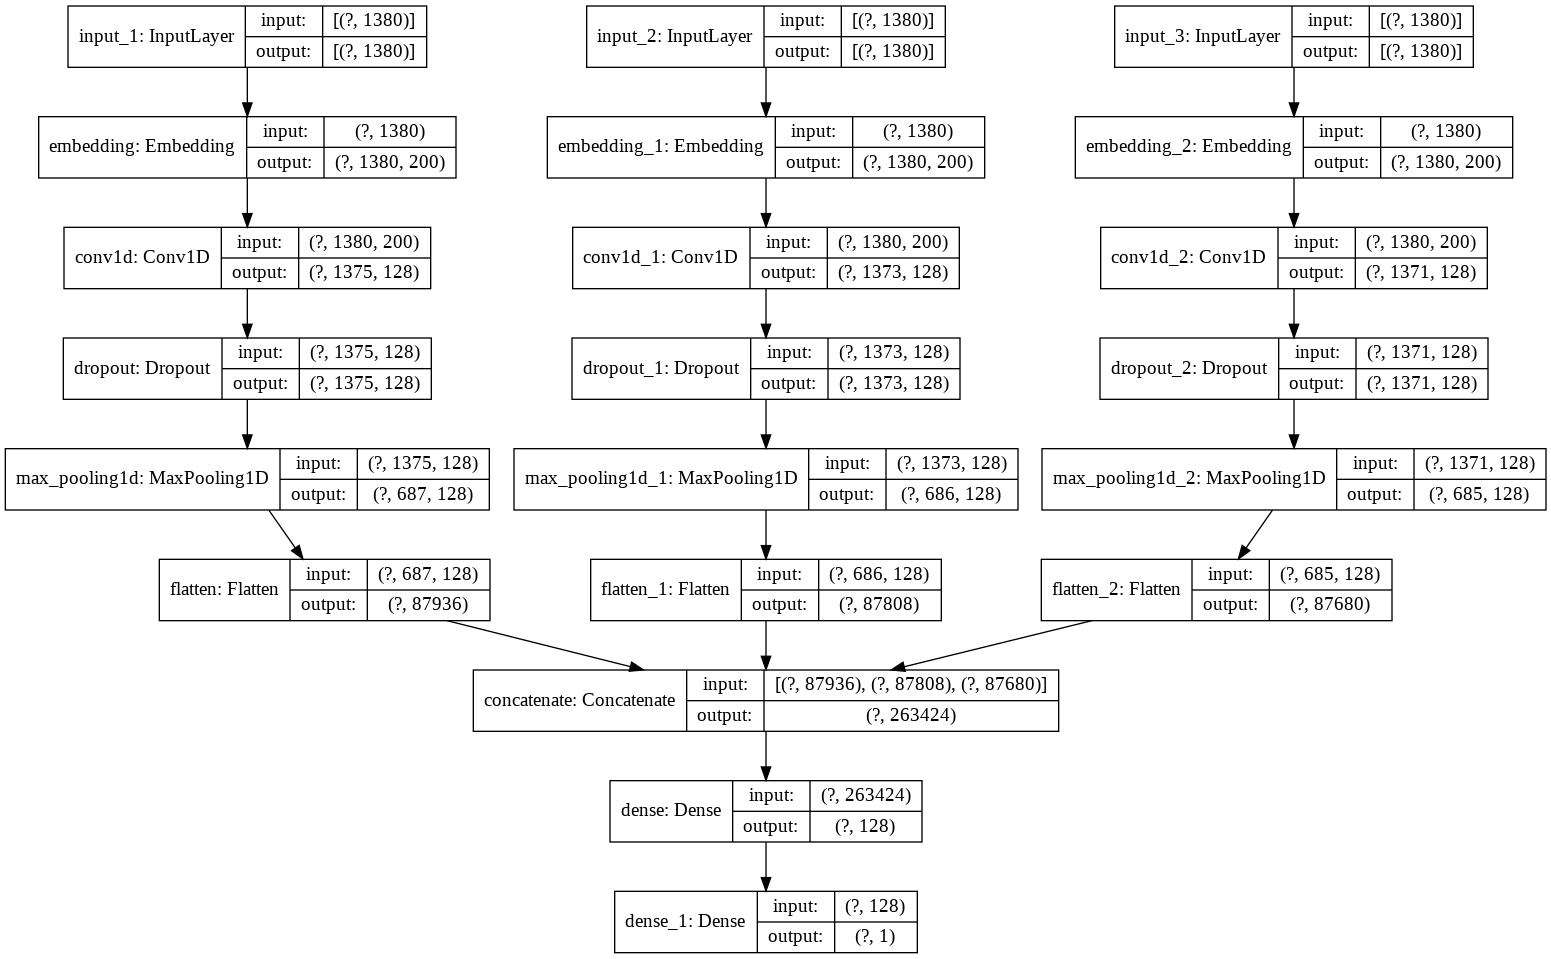

In [22]:
# plot the model
tf.keras.utils.plot_model(model, to_file='multichannel_cnn_txt.png', show_shapes=True)

- Next, we fit the network on the training data. We use a binary cross entropy loss function because the problem we are learning is a binary classification problem. The efficient Adam implementation of stochastic gradient descent is used and we keep track of accuracy in addition to loss during training. 

- We use early stopping which stops training when a monitored metric in our case validation loss i.e. 'val_loss' has stopped improving. We use a patience of 3 for stopping the training. 

- We also use model checkpoint which monitors validation loss i.e. 'val_loss' and only saves the model if the 'val_loss' for current epoch has been reduced than previous epoch.

- The model is trained for 20 epochs or 20 passes through the training data with a batch size of 8.

- The network configuration and training schedule were found with a little trial and error but are by no means optimal for this problem.

In [0]:
# compile the network
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# define early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

# define model checkpoint
mckpt = tf.keras.callbacks.ModelCheckpoint('multichannel_cnn_txt_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [17]:
# fit the network
history = model.fit(x=[X_train, X_train, X_train], y=array(trainlabels), validation_data=([X_test, X_test, X_test], array(testlabels)), epochs=20, batch_size=8, callbacks=[es, mckpt])

Epoch 1/20
225/225 [==============================] - ETA: 0s - loss: 0.7690 - accuracy: 0.5933
Epoch 00001: val_loss improved from inf to 0.51048, saving model to multichannel_cnn_txt_model.h5
225/225 [==============================] - 67s 296ms/step - loss: 0.7690 - accuracy: 0.5933 - val_loss: 0.5105 - val_accuracy: 0.7450
Epoch 2/20
225/225 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9267
Epoch 00002: val_loss improved from 0.51048 to 0.29822, saving model to multichannel_cnn_txt_model.h5
225/225 [==============================] - 66s 293ms/step - loss: 0.1727 - accuracy: 0.9267 - val_loss: 0.2982 - val_accuracy: 0.8850
Epoch 3/20
225/225 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9972
Epoch 00003: val_loss did not improve from 0.29822
225/225 [==============================] - 63s 281ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.3515 - val_accuracy: 0.8900
Epoch 4/20
225/225 [==============================] - ETA: 

- We can see that the accuracy on the training dataset is excellent at 100%. We can also see that the accuracy of the model on the unseen test dataset is also very impressive at 90%

In [18]:
# evaluate the model on test data
loss, accuracy = model.evaluate([X_test, X_test, X_test], array(testlabels))

7/7 [==============================] - 0s 21ms/step - loss: 0.3673 - accuracy: 0.9000


In [19]:
# Get accuracy on test dataset
print(f'Test Accuracy : {accuracy*100:.2f}')

Test Accuracy : 90.00


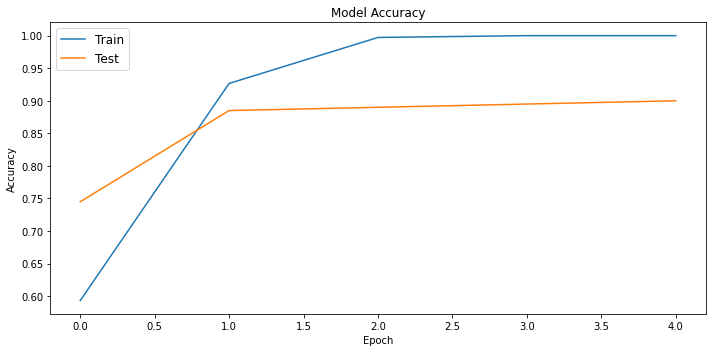

In [20]:
# Plot Model Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(labels=['Train', 'Test'], fontsize='large')
plt.tight_layout()

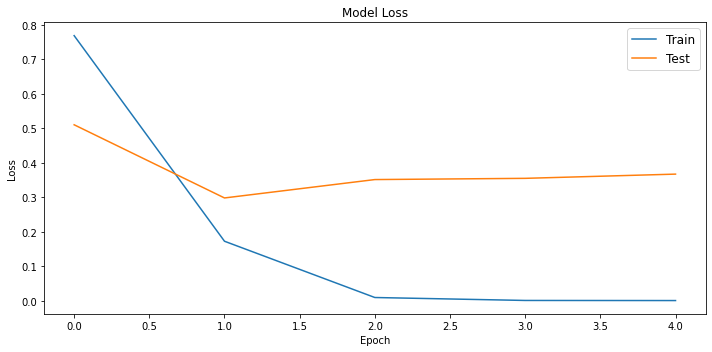

In [21]:
# Plot Model Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(labels=['Train', 'Test'], fontsize='large')
plt.tight_layout()

[How to Develop a Multichannel CNN Model for Text Classification)](https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/)

[Convolutional Neural Networks for Sentence Classification](https://arxiv.org/pdf/1408.5882.pdf)

[Best Practices for Text Classification with Deep Learning](https://machinelearningmastery.com/best-practices-document-classification-deep-learning/)